## Percobaan 2 

Ekualisasi dan Mean

In [21]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [22]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            # Ambil channel hijau dari gambar
            green = img[:, :, 1]
            green = cv.resize(green, (150, 150)) # Resize gambar yag diambil
            green = green.astype(np.uint8)

            # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            # img = cv.resize(img, (150, 150))  # Resize ke ukuran tetap
            # img = img.astype(np.uint8)

            data.append(green)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

## Data Preparation

### Define Preprocessing

In [23]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

# def mean_filter(img, kernel_size=3):
#     pad = kernel_size // 2
#     padded = np.pad(img, pad, mode='constant', constant_values=0)
#     result = np.zeros_like(img, dtype=np.float32)  # Gunakan float32 untuk akurasi

#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             window = padded[i:i+kernel_size, j:j+kernel_size]
#             total = np.sum(window)
#             result[i, j] = total / (kernel_size * kernel_size)
    
#     return np.clip(result, 0, 255).astype(np.uint8)  # Clip dan konversi ke uint8

def median_filter(img, kernel_size=3):
    pad_size = kernel_size // 2
    padded = np.pad(img, pad_size, mode='edge')
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Ambil jendela lokal
            window = padded[i:i+kernel_size, j:j+kernel_size].flatten()
            # Hitung median
            median_val = np.median(window)
            filtered[i, j] = median_val

    return filtered.astype(np.uint8)


## Preprocessing

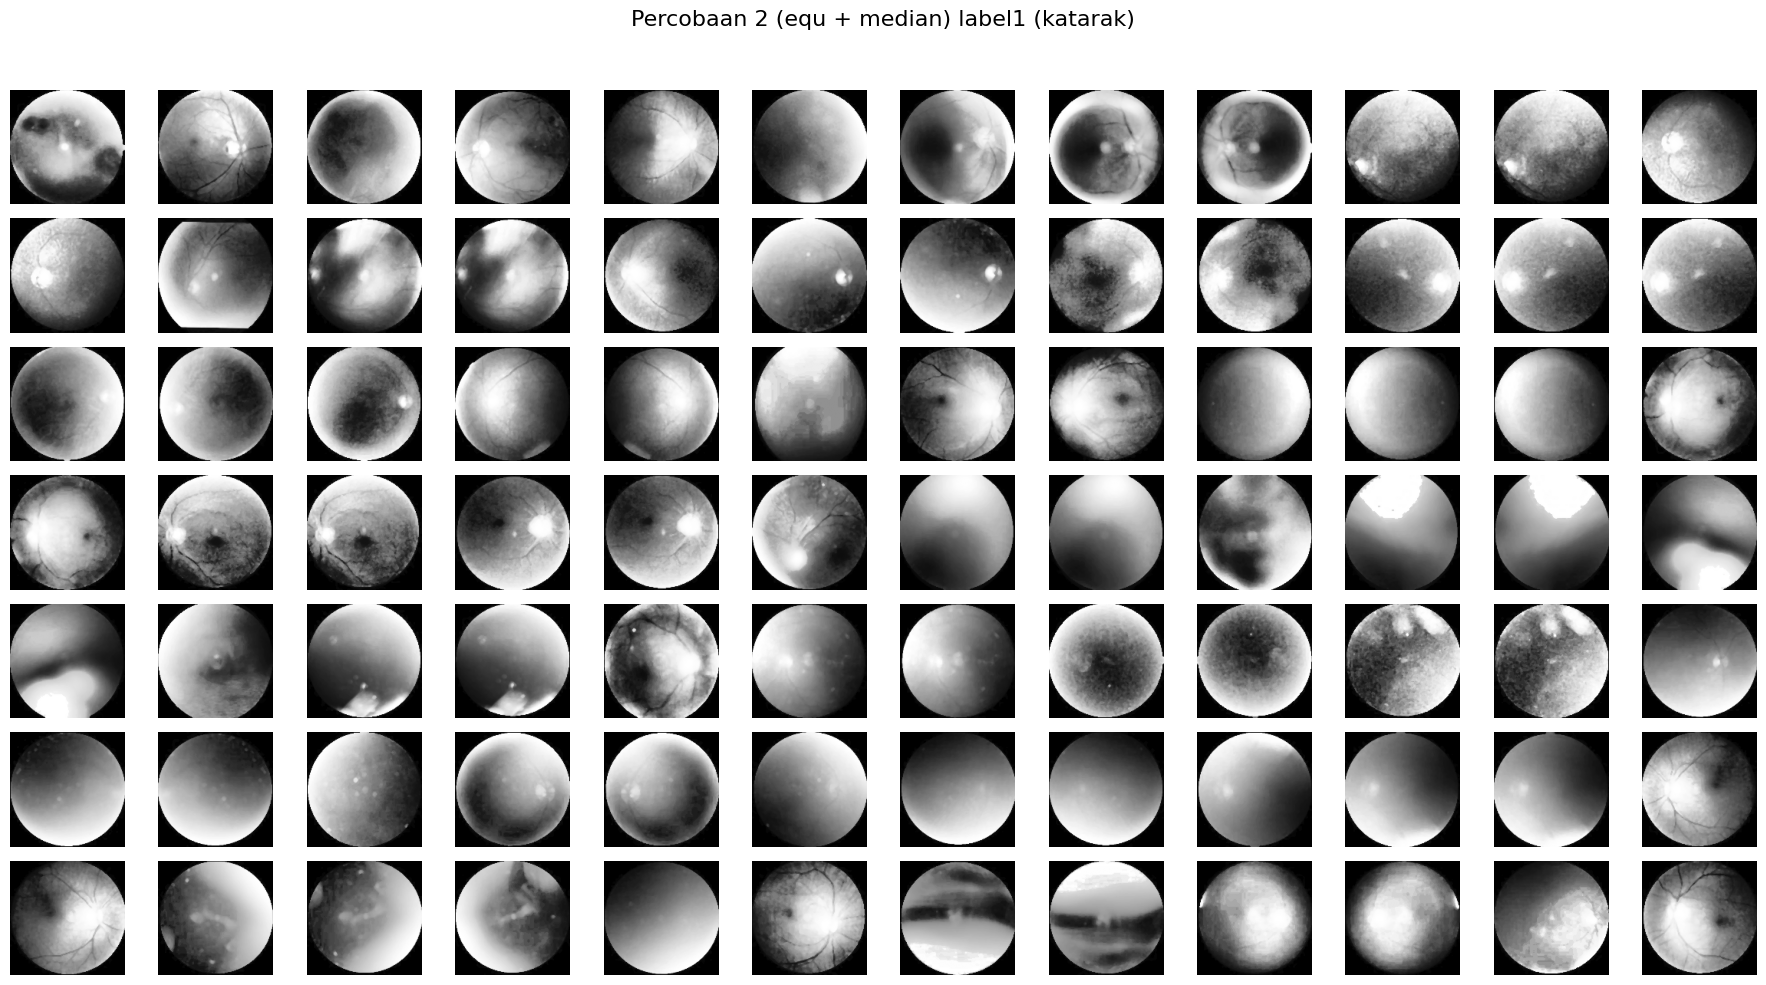

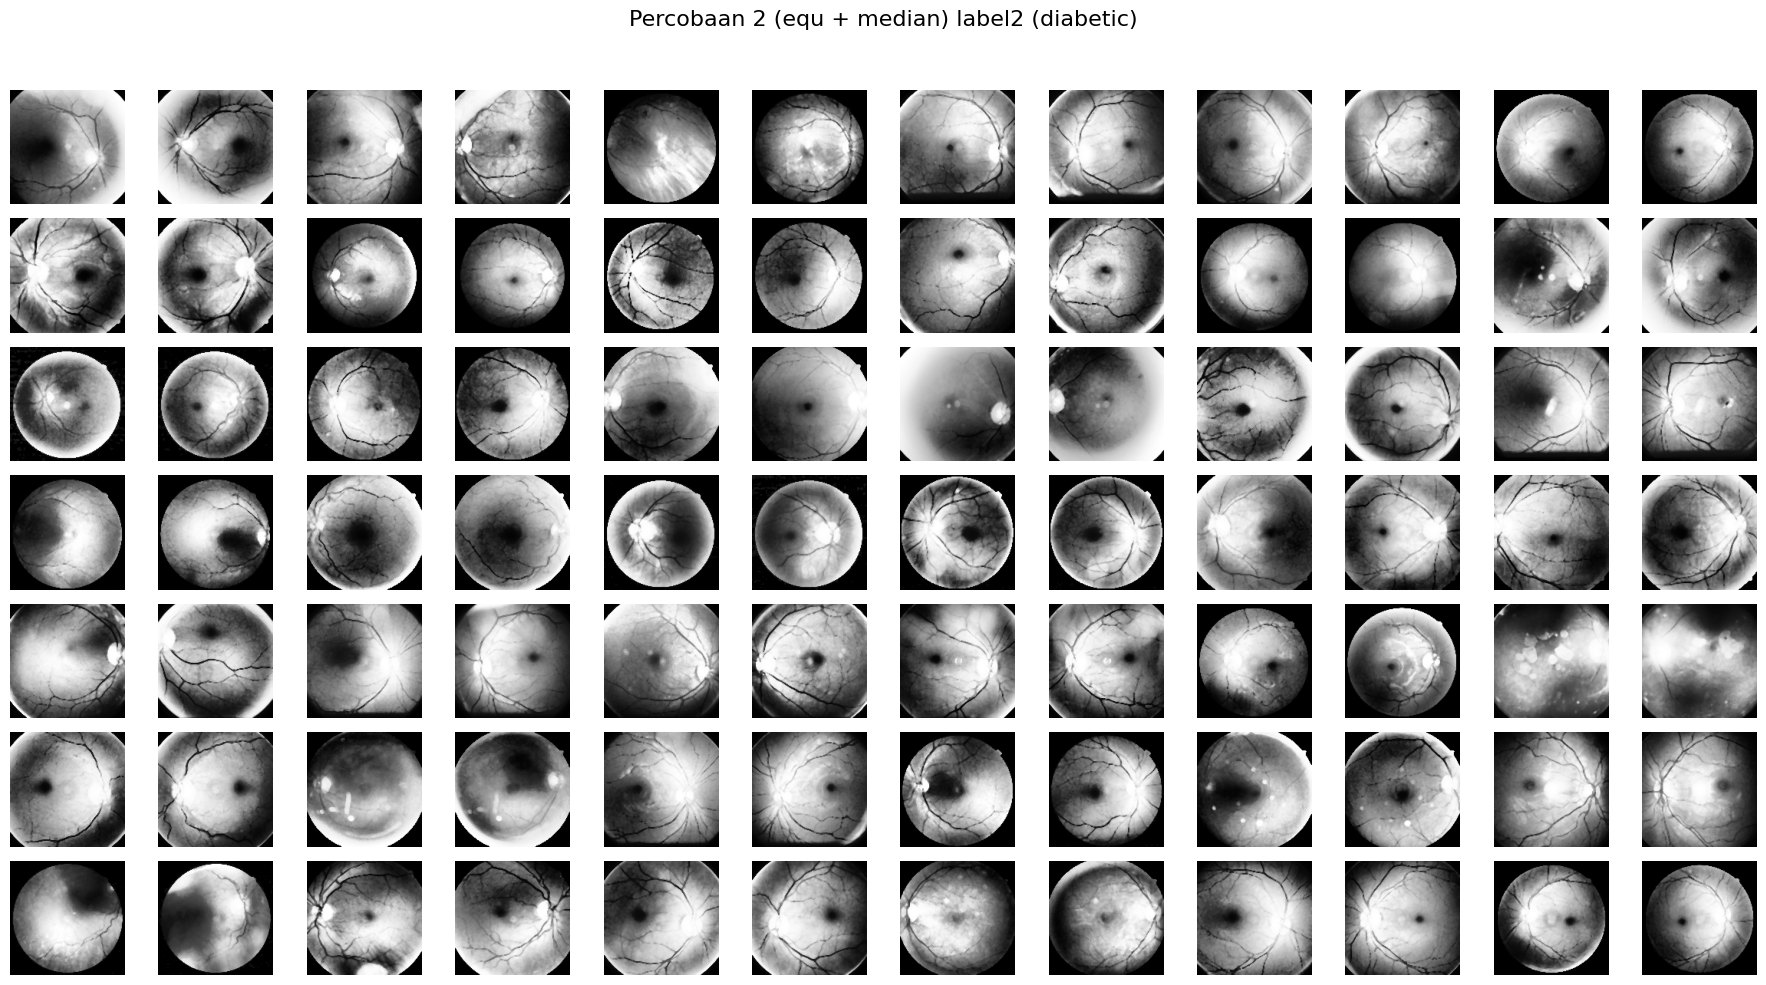

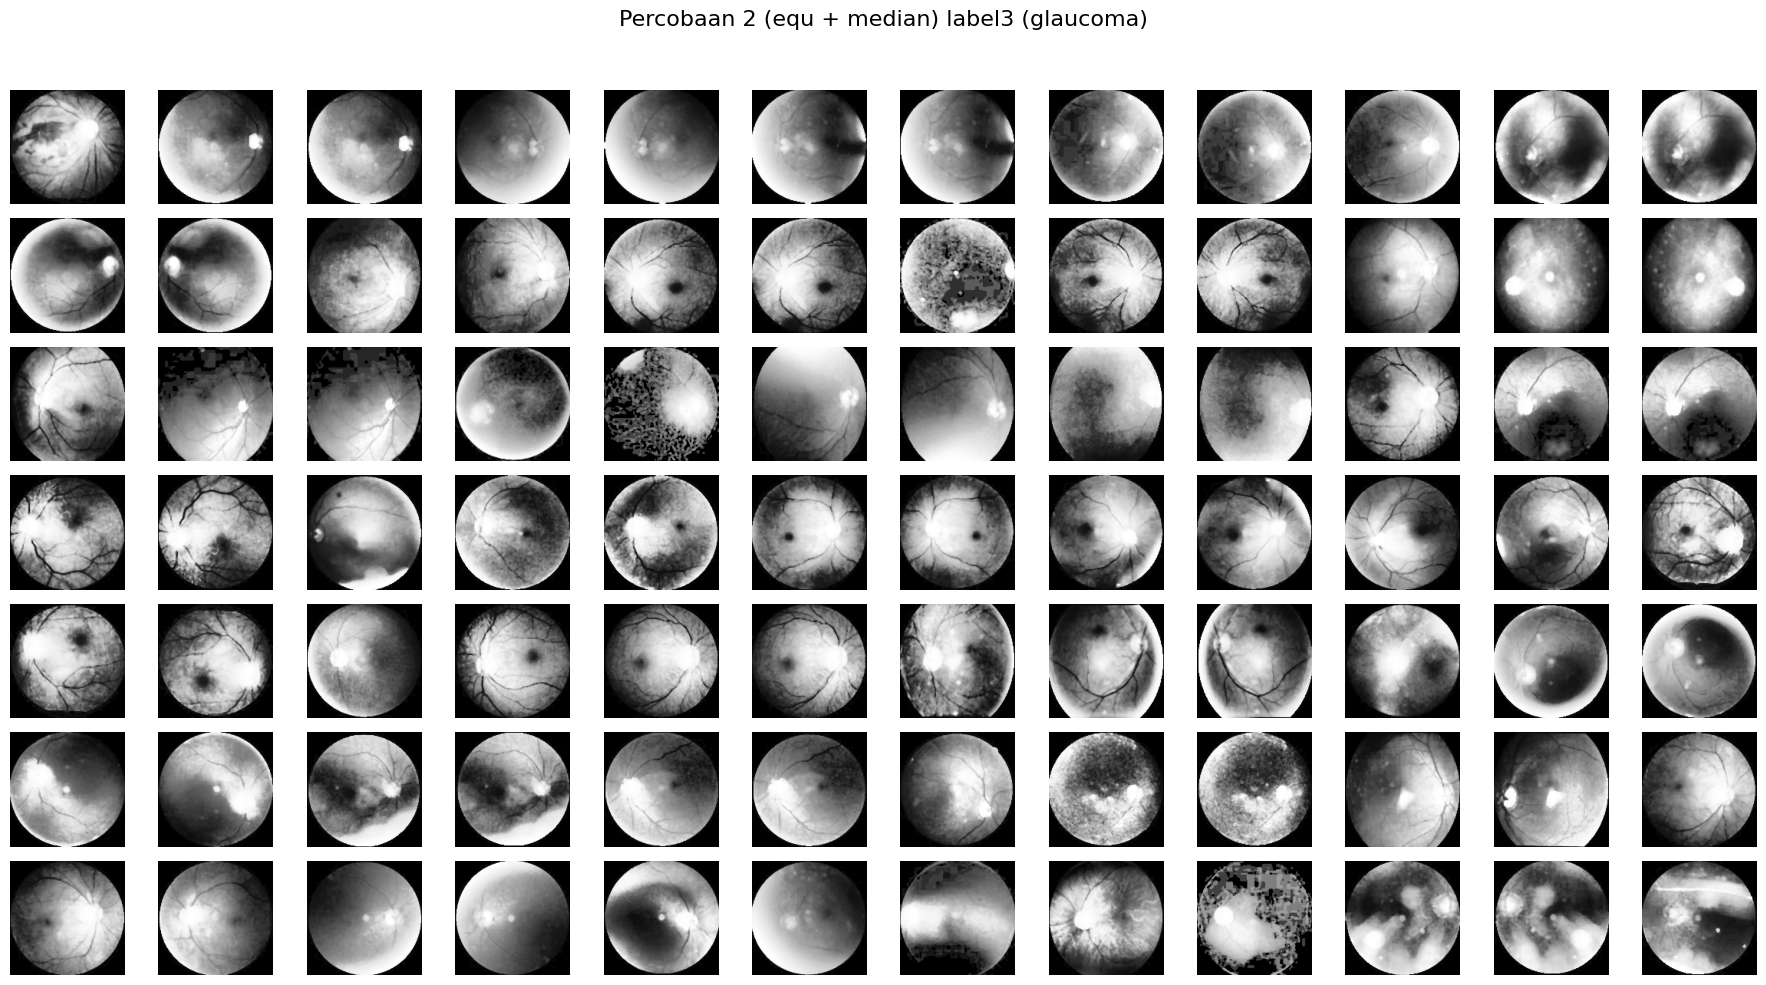

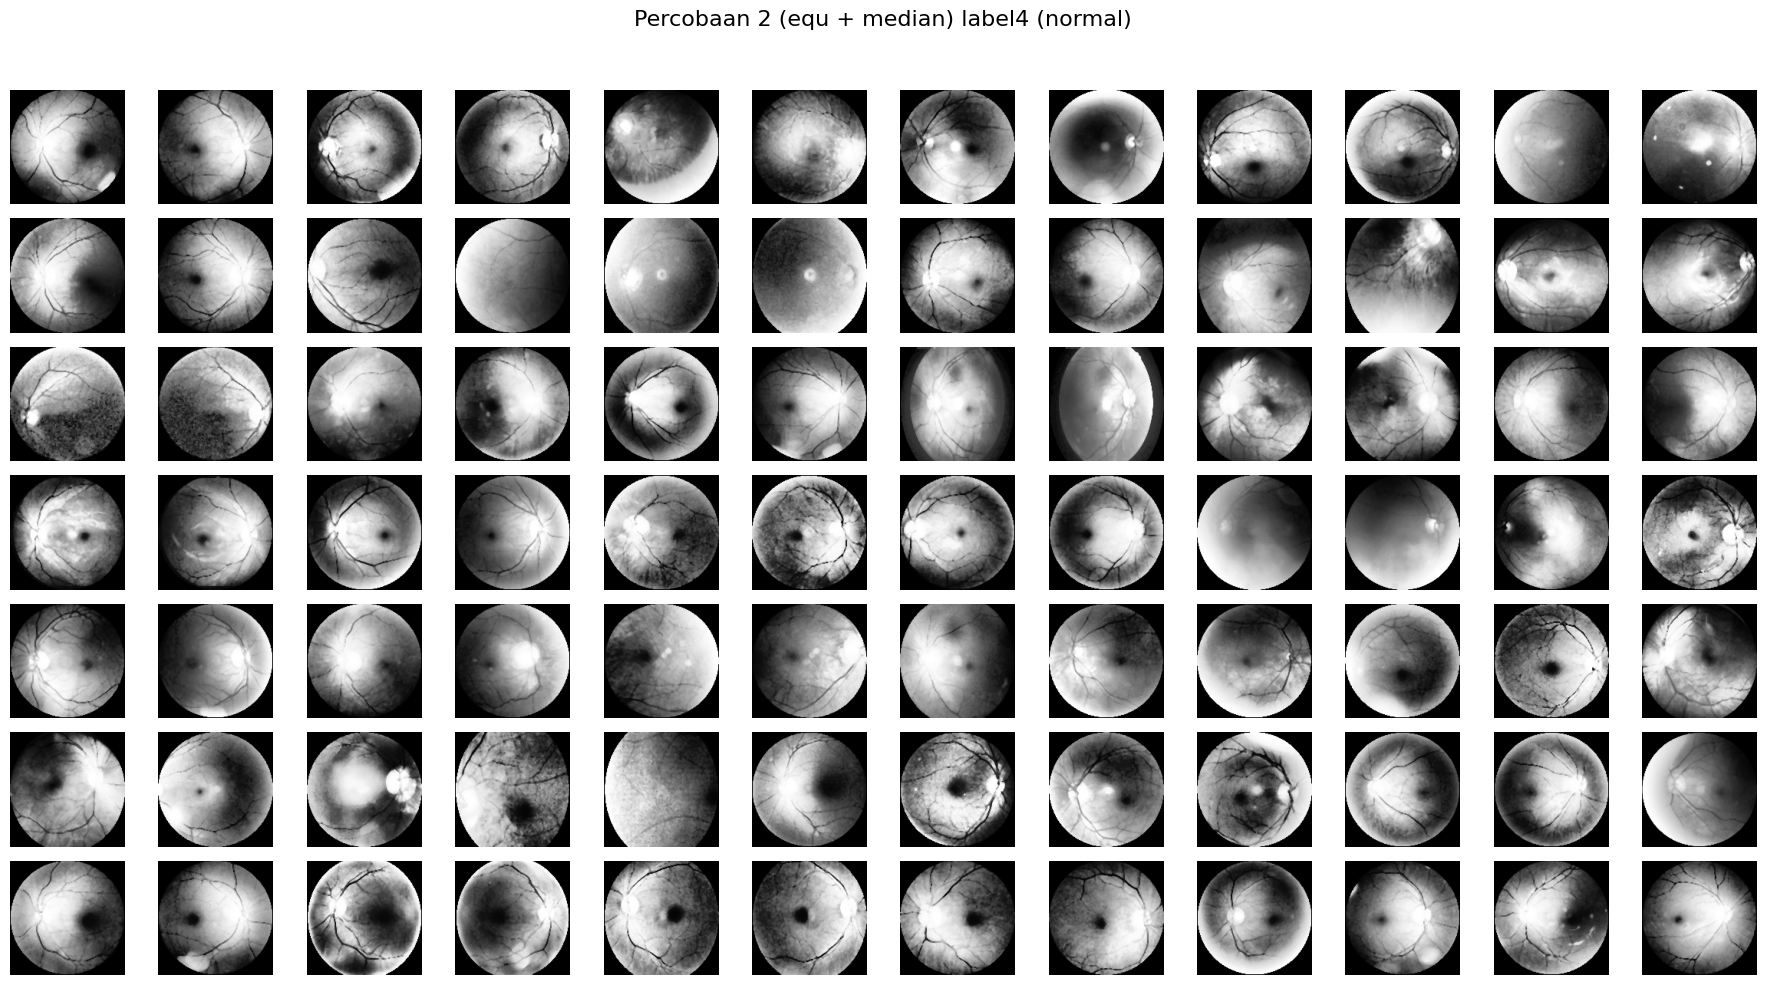

In [24]:
def percobaan2(green):
    #img_mean = mean_filter(green)
    img_eq = histogram_equalization(green)
    img_med = median_filter(img_eq)
    return img_med

dataPreprocessed = [percobaan2(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 2 (equ + median) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

## Ekstraksi Fitur

In [25]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [26]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [27]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df2 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan2')
display(df2)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0    218.302461     0.977245  0.169554     0.633055       3.684743  0.028749   
1    170.550022     0.981917  0.160824     0.530969       3.830470  0.025864   
2    305.734183     0.967434  0.159551     0.521729       4.358434  0.025456   
3    164.482864     0.982135  0.173842     0.580679       3.163579  0.030221   
4    100.642416     0.989258  0.166268     0.515678       3.293154  0.027645   
..          ...          ...       ...          ...            ...       ...   
331  149.900537     0.983040  0.191731     0.506844       4.883266  0.036761   
332  380.006622     0.956714  0.197166     0.491857       5.567696  0.038874   
333  113.762237     0.986972  0.201207     0.530739       3.958479  0.040484   
334  182.082416     0.979141  0.201842     0.541853       4.790246  0.040740   
335   65.935391     0.992377  0.200757     0.534804       3.596689  0.040303   

      entropy       tahap  
0    5.079249  percobaan2  
1    5.930123  percobaan2  
2    5.745456  percobaan2  
3    5.427564  percobaan2  
4    6.044510  percobaan2  
..        ...         ...  
331  5.876514  percobaan2  
332  5.850797  percobaan2  
333  5.544661  percobaan2  
334  5.531248  percobaan2  
335  5.752163  percobaan2  

[336 rows x 8 columns]

In [28]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [29]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [30]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan2.csv')
hasilEkstrak


Filename             Label   Contrast0  Contrast45  Contrast90  \
0     _0_4015166.jpg  label1 (katarak)  218.302461  305.336156  252.562506   
1    _10_3215668.jpg  label1 (katarak)  170.550022  215.697671  159.146890   
2    _11_7158929.jpg  label1 (katarak)  305.734183  448.482861  281.866264   
3    _12_5233869.jpg  label1 (katarak)  164.482864  232.466150  138.491767   
4    _13_3987009.jpg  label1 (katarak)  100.642416  147.696770   66.821029   
..               ...               ...         ...         ...         ...   
331      8_right.jpg   label4 (normal)  149.900537  240.537949  151.709978   
332     939_left.jpg   label4 (normal)  380.006622  518.045223  315.137181   
333    939_right.jpg   label4 (normal)  113.762237  174.008783   95.123177   
334     951_left.jpg   label4 (normal)  182.082416  331.154453  204.146219   
335    951_right.jpg   label4 (normal)   65.935391  111.695014   71.322998   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     389.551732      0.633055       0.537810       0.556734        0.474384   
1     274.814558      0.530969       0.454436       0.517373        0.435797   
2     450.157200      0.521729       0.449988       0.560970        0.457076   
3     239.985902      0.580679       0.531384       0.603297        0.500321   
4     123.944687      0.515678       0.455337       0.553594        0.458469   
..           ...           ...            ...            ...             ...   
331   221.687447      0.506844       0.416238       0.502805        0.423182   
332   541.292284      0.491857       0.406613       0.495637        0.416836   
333   145.034233      0.530739       0.464533       0.543478        0.456108   
334   254.167920      0.541853       0.448258       0.536939        0.471775   
335   100.422008      0.534804       0.457346       0.524818        0.448856   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.027948  0.025218  0.169554  0.160310  0.167176   0.158801   
1    ...  0.025831  0.023725  0.160824  0.153585  0.160721   0.154028   
2    ...  0.025630  0.023270  0.159551  0.152179  0.160095   0.152546   
3    ...  0.029924  0.027352  0.173842  0.166121  0.172984   0.165385   
4    ...  0.028050  0.025613  0.166268  0.160039  0.167482   0.160039   
..   ...       ...       ...       ...       ...       ...        ...   
331  ...  0.036739  0.033929  0.191731  0.184748  0.191674   0.184197   
332  ...  0.038931  0.036330  0.197166  0.190250  0.197309   0.190604   
333  ...  0.040441  0.037560  0.201207  0.193727  0.201100   0.193803   
334  ...  0.040823  0.037871  0.201842  0.194324  0.202047   0.194605   
335  ...  0.040313  0.037366  0.200757  0.193456  0.200780   0.193302   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.977245       0.968034       0.973674        0.959218  
1        0.981917       0.977011       0.983107        0.970711  
2        0.967434       0.952041       0.969978        0.951862  
3        0.982135       0.974660       0.984963        0.973840  
4        0.989258       0.984186       0.992873        0.986730  
..            ...            ...            ...             ...  
331      0.983040       0.972687       0.982833        0.974827  
332      0.956714       0.940760       0.964104        0.938101  
333      0.986972       0.979995       0.989106        0.983326  
334      0.979141       0.961913       0.976614        0.970767  
335      0.992377       0.987035       0.991754        0.988343  

[336 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

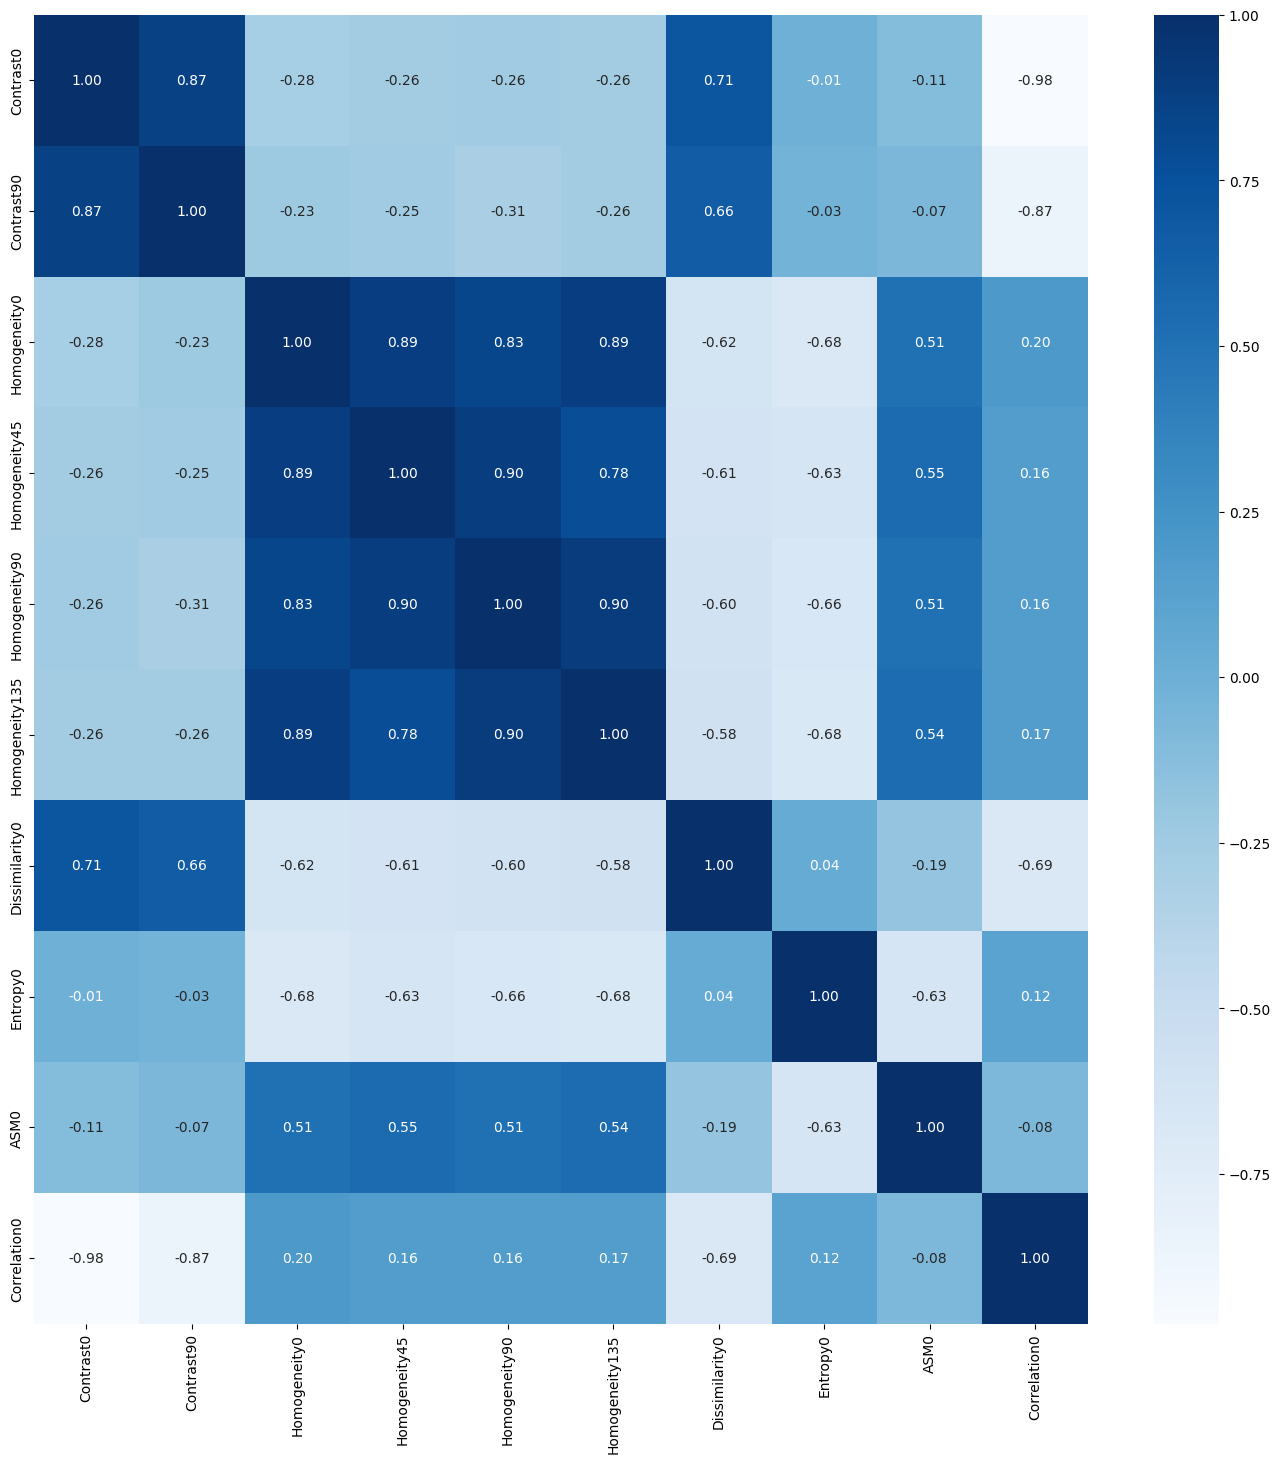

In [31]:
# Selection Correlation
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

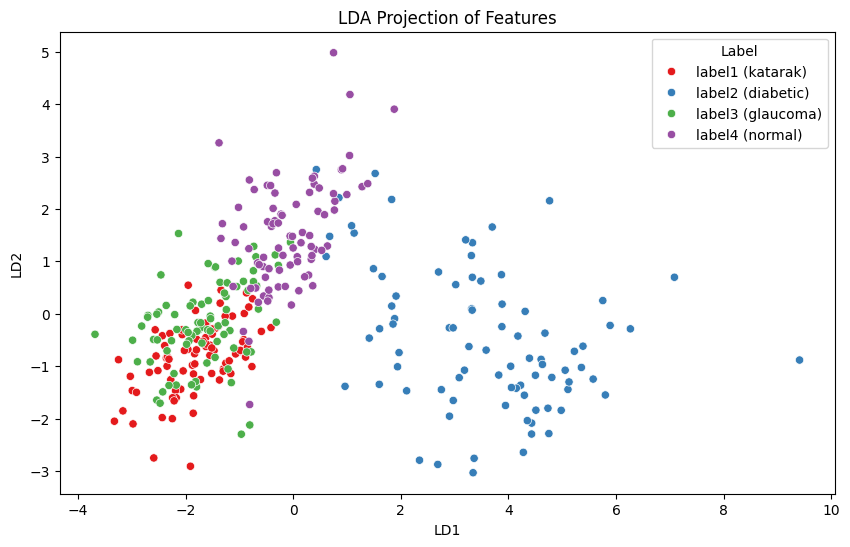

In [32]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


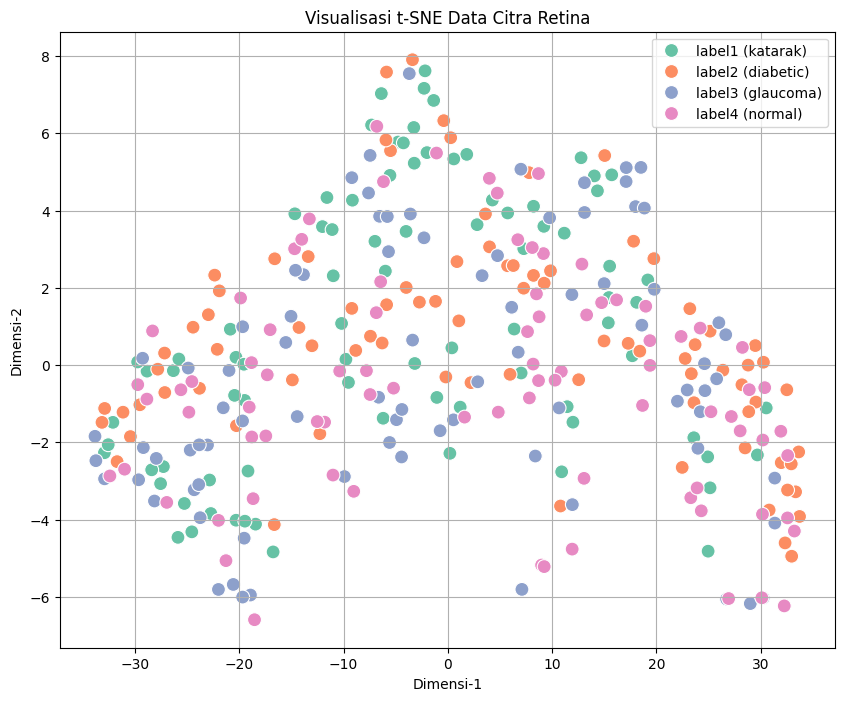

In [33]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

In [34]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(268, 10)
(68, 10)
(268,)
(68,)


## Feature Normalization



In [35]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [36]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [37]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.97      0.98      0.98        64
label2 (diabetic)       0.96      0.99      0.97        67
label3 (glaucoma)       1.00      0.97      0.99        72
  label4 (normal)       0.98      0.97      0.98        65

         accuracy                           0.98       268
        macro avg       0.98      0.98      0.98       268
     weighted avg       0.98      0.98      0.98       268

[[63  1  0  0]
 [ 0 66  0  1]
 [ 1  1 70  0]
 [ 1  1  0 63]]
Accuracy: 0.9776119402985075

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.89      0.85      0.87        20
label2 (diabetic)       0.71      0.88      0.79        17
label3 (glaucoma)       0.50      0.50      0.50        12
  label4 (normal)       0.69      0.58      0.63        19

         accuracy                           0.72        68
        macro avg       0.70 

### Train SVM Classifier

In [38]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.75      0.70      0.73        64
label2 (diabetic)       0.96      0.82      0.89        67
label3 (glaucoma)       0.73      0.76      0.75        72
  label4 (normal)       0.72      0.85      0.78        65

         accuracy                           0.78       268
        macro avg       0.79      0.78      0.79       268
     weighted avg       0.79      0.78      0.79       268

[[45  0 11  8]
 [ 1 55  4  7]
 [10  1 55  6]
 [ 4  1  5 55]]
Accuracy: 0.7835820895522388

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.61      0.70      0.65        20
label2 (diabetic)       0.93      0.82      0.88        17
label3 (glaucoma)       0.25      0.17      0.20        12
  label4 (normal)       0.64      0.74      0.68        19

         accuracy                           0.65        68
        macro avg       0.61

### Train KNN Classifier

In [39]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.73      0.89      0.80        64
label2 (diabetic)       0.91      0.88      0.89        67
label3 (glaucoma)       0.69      0.69      0.69        72
  label4 (normal)       0.85      0.69      0.76        65

         accuracy                           0.79       268
        macro avg       0.80      0.79      0.79       268
     weighted avg       0.79      0.79      0.79       268

[[57  1  5  1]
 [ 2 59  3  3]
 [16  2 50  4]
 [ 3  3 14 45]]
Accuracy: 0.7873134328358209

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.57      0.65      0.60        20
label2 (diabetic)       0.74      0.82      0.78        17
label3 (glaucoma)       0.50      0.50      0.50        12
  label4 (normal)       0.71      0.53      0.61        19

         accuracy                           0.63        68
        macro avg       0.63

## Evaluasi Dengan Confussion Matrix

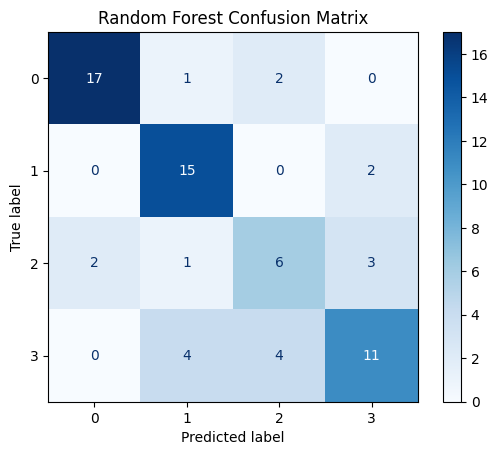

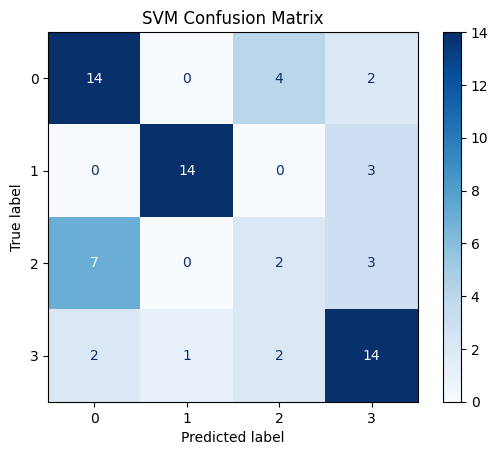

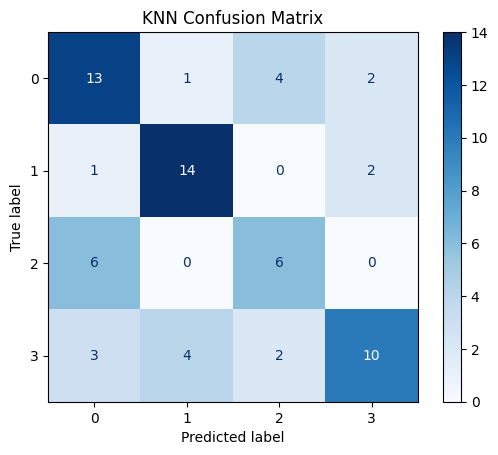

In [40]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")